<a href="https://colab.research.google.com/github/andygoosh/crowdanalytix/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install scikit-plot

import sklearn
if '0.22' != sklearn.__version__:
  !pip install -U scikit-learn
  import os
  os.kill(os.getpid(), 9)

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import random as rn
import pandas as pd
import xarray
import requests
import datetime

import os
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from pathlib import Path
import scikitplot as skplt
from google.colab import files, drive
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

print(tf.test.gpu_device_name())
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
#assert ('0.22' == sklearn.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
if sklearn.__version__ == '0.22':
  from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
warnings.filterwarnings('ignore')
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

GDRIVE_PATH = '/content/drive'
drive.mount(GDRIVE_PATH, force_remount=True)
PATH = os.path.join(GDRIVE_PATH, 'My Drive/crowdanalytix/', '')

Populating the interactive namespace from numpy and matplotlib
TensorFlow 2.x selected.
/device:GPU:0
2.1.0-rc1
2.2.4-tf
0.22


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


In [2]:
df_train = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Train_File.csv')) #, dtype={'field1': np.float64, 'field14': np.float64})
df_test = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Test_File.csv'), index_col='unique_id') #, dtype={'field1': np.float64, 'field14': np.float64})
df_train.describe()

,row_id,well_id,GR,label
count,4400000.000000,4400000.000000,4400000.000000,4400000.000000
mean,549.500000,1999.500000,109.273256,1.184489
std,317.542553,1154.700634,34.242397,1.465016
min,0.000000,0.000000,-3.181915,0.000000
25%,274.750000,999.750000,81.792217,0.000000
50%,549.500000,1999.500000,120.384935,0.000000
75%,824.250000,2999.250000,134.729051,2.000000
max,1099.000000,3999.000000,197.061419,4.000000


In [0]:
X = df_train[['label', 'GR']]
X['id'] = df_train['well_id']*1100 + df_train['row_id']

data = pd.DataFrame(X, index=X['id']).drop(['id'], axis=1)

In [0]:
df_test.head()

In [0]:
df_train.tail()

In [0]:
df_test.describe()

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

In [0]:
def plot_cm_and_roc(model, X, y, title=''):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle(f'{type(model).__name__} {title}')
  skl.metrics.plot_confusion_matrix(model, X, y, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)
  '''
  pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.suptitle(f'{type(model).__name__} {title}')
  skplt.metrics.plot_confusion_matrix(y, pred_proba.argmax(axis=1), ax=ax1)
  skplt.metrics.plot_roc(y, pred_proba, ax=ax2)
  '''
  plt.show()

def oof_estimate_plot(model):
  X_oof, y_off = prepare_data(df_oof)
  plot_cm_and_roc(model, X_oof, y_off, 'oof')

  if hasattr(model, 'best_ntree_limit'): pred = model.predict_proba(X_oof, ntree_limit=model.best_ntree_limit) 
  else: pred = model.predict_proba(X_oof)

  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  return oof

def plot_cv_scores(scores):
  # plot CV scores
  plt.figure()
  plt.xlabel('Number of folds')
  plt.ylabel('Cross validation score')
  plt.plot(range(1, len(scores) + 1), scores)
  plt.show()

def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.subplots(figsize=(15,4))

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

## Neural Networks

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(BLOCK, 1)),
    tf.keras.layers.Conv1D(256, kernel_size=3, padding='same'),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Conv1D(128, kernel_size=3, padding='same'),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Conv1D(61, kernel_size=3, padding='same'),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5500),
    tf.keras.layers.Reshape(target_shape=(BLOCK,5)),
    tf.keras.layers.Dense(TARGET_TYPES, activation='softmax'),
  ])
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              metrics=[#tf.keras.metrics.AUC(), 
                      'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )
model.summary()

In [0]:
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Conv1D, MaxPool1D, Bidirectional
tf.keras.backend.clear_session()

EPOCHS = 100
BS = 200
BLOCK=1100

X, y = data.iloc[:, 1:], data.iloc[:, :1]
#X, _, y, _ = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.8)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.1)

center, scale = X_train.mean().values, X_train.std().values
X_train = (X_train.values - center)/scale
X_cv = (X_cv.values - center)/scale
y_train = y_train.values.ravel()
y_cv = y_cv.values.ravel()

X_train = X_train.reshape(-1, BLOCK, 1)
y_train_ = y_train.reshape(-1, BLOCK, 1)

X_cv = X_cv.reshape(-1, BLOCK, 1)
y_cv_ = y_cv.reshape(-1, BLOCK, 1)

FEATURES_NUM = 1
TARGET_TYPES = 5
weight_decay = 0.1
#
model = tf.keras.Sequential([
    Input(shape=(BLOCK, 1), batch_size=BS),
    Bidirectional(LSTM(64, return_sequences=True)), #kernel_regularizer=keras.regularizers.l2(weight_decay))),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dense(TARGET_TYPES, activation='softmax'),
  ])
optimizer=keras.optimizers.Adam(lr=1e-2)
#optimizer=keras.optimizers.RMSprop(lr=1e-3)

model.compile(optimizer=optimizer,
              metrics=[#tf.keras.metrics.AUC(), 
                      #'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )
model.summary()
model.reset_states()

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()
#lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1, patience=10, monitor='val_loss', mode='min')
early_stop = keras.callbacks.EarlyStopping( patience=20, monitor='val_loss', mode='min' )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        model_save, 
        lr_schedule,
        reset_states
        ]

history = model.fit(X_train, y_train_,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv_),
          callbacks=callbacks)

#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])

model = keras.models.load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

print(f'train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')

model.reset_states()

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (200, 1100, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (200, 1100, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (200, 1100, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (200, 1100, 128)          98816     
_________________________________________________________________
dense (Dense)                (200, 1100, 5)            645       
Total params: 330,885
Trainable params: 330,885
Non-trainable params: 0
_________________________________________________________________
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 19s 5ms/samp

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (50, 1100, 512)           528384    
_________________________________________________________________
dense (Dense)                (50, 1100, 5)             2565      
Total params: 530,949
Trainable params: 530,949
Non-trainable params: 0
_________________________________________________________________
BS:50


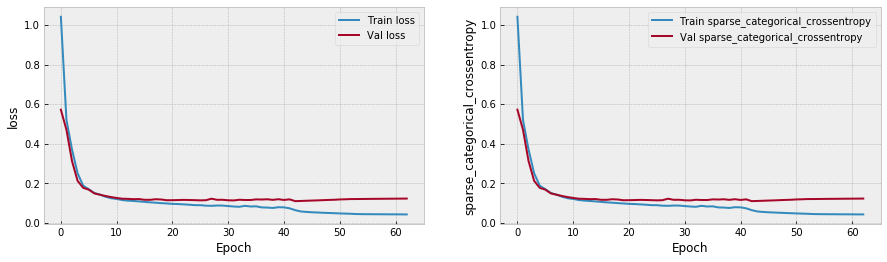

loss: 0.1104 sparse_categorical_crossentropy: 0.1104 


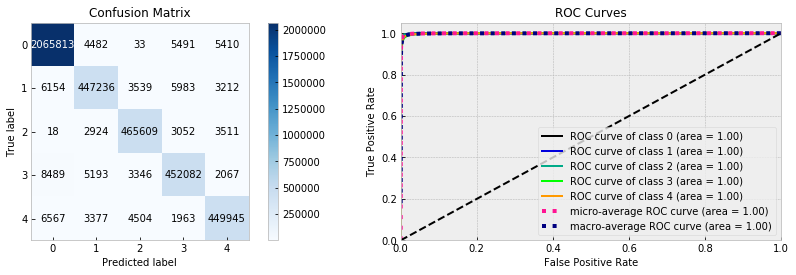

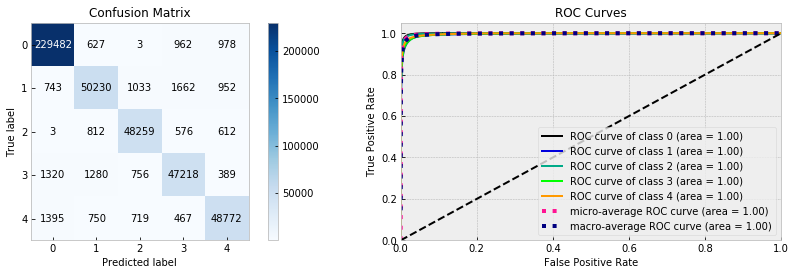

In [0]:
model = keras.models.load_model('my_checkpoint.h5')
model.summary()

plot_history(history, model.metrics_names)

print(f'BS:{BS} train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')

model.reset_states()

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

## Submit RNN Result

In [0]:
X_test = df_test[['GR']]
X_test = (X_test.values - center)/scale
X_test = X_test.reshape(-1, BLOCK, FEATURES_NUM)

model = keras.models.load_model('my_checkpoint.h5')

test_pred_proba = model.predict(X_test, use_multiprocessing=True)
test_pred_proba = test_pred_proba.reshape(-1, TARGET_TYPES)
test_pred = test_pred_proba.argmax(axis=1)

pd.DataFrame(test_pred, index=df_test.index, columns=['label']).to_csv('submission.csv')

In [0]:
test_pred.sum()

2409098

## Tree models

In [0]:

X, y = data.iloc[:, 1:], data.iloc[:, :1]

X, _, y, _ = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.8)
X, X_oof, y, y_oof = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.1)


n_folds = 2
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = XGBClassifier(objective="multi:softprob", random_state=RS)
scores = cross_val_score(model, X, y, scoring='roc_auc_ovr', verbose=1, n_jobs=-1, cv=skf)

model.fit(X, y,
        eval_set=[(X_oof, y_oof)],
        early_stopping_rounds=200,
        verbose=False,
        #eval_metric = 'roc_auc_ovr', 
        )

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores)

## Submit the result

In [0]:
X_test = df_test[['GR']]
#X_test = (X_test.values - center)/scale

test_pred_proba = model.predict_proba(X_test) #, use_multiprocessing=True)
test_pred = test_pred_proba.argmax(axis=1)

df_test_pred=pd.DataFrame(test_pred, index=df_test.index, columns=['label']).to_csv('submission.csv')
df_test_pred

In [0]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)